In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, \
                            compute_log_likelihood_by_week, \
                            ACTUAL_TRAJ, UNCERTAINTY_PARAMS, \
                            get_positives_by_week, get_true_positives_by_week
import sklearn 
from sklearn.preprocessing import PolynomialFeatures

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]

path2 = 'fall_2021_prior_samples:1633456006'
files2 = [f for f in listdir(path2) if isfile(join(path2, f)) and 'with_trajectories' in f ]


from vax_sims_LHS_samples import *

import numpy as np

from scipy.stats import poisson, norm

from statsmodels.api import OLS

import matplotlib.pyplot as plt 
import pandas as pd


In [2]:
len(files2)

6886

In [3]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points


In [4]:
sampled_points2 = {}
aggregated_trajs2 = {}

count = 0
for f in files2:
    with open(join(path2, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points2[f] = point
        aggregated_trajs2[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
 

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points
Loaded 1100 points
Loaded 1200 points
Loaded 1300 points
Loaded 1400 points
Loaded 1500 points
Loaded 1600 points
Loaded 1700 points
Loaded 1800 points
Loaded 1900 points
Loaded 2000 points
Loaded 2100 points
Loaded 2200 points
Loaded 2300 points
Loaded 2400 points
Loaded 2500 points
Loaded 2600 points
Loaded 2700 points
Loaded 2800 points
Loaded 2900 points
Loaded 3000 points
Loaded 3100 points
Loaded 3200 points
Loaded 3300 points
Loaded 3400 points
Loaded 3500 points
Loaded 3600 points
Loaded 3700 points
Loaded 3800 points
Loaded 3900 points
Loaded 4000 points
Loaded 4100 points
Loaded 4200 points
Loaded 4300 points
Loaded 4400 points
Loaded 4500 points
Loaded 4600 points
Loaded 4700 points
Loaded 4800 points
Loaded 4900 points
Loaded 5000 points
Loaded 5100 points
Loaded 5200 points
Loaded 5300 points
Lo

In [5]:
def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)



In [6]:
UNCERTAINTY_PARAMS = ['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult', 'outside_infection_rate_mult',
                      'cases_isolated_per_contact_trace', 'initial_ID_prevalence']

UNCERTAINTY_PARAM_RANGES = {
    'vax_susc_mult': (0.097608, 0.941192), # 0.5194 +/- 1.96 * 0.2152
    'vax_transmission_mult': (0.25, 1),
    'contacts_per_day_mult': (0.9,2.7),
    'outside_infection_rate_mult': (1, 5),
    'cases_isolated_per_contact_trace': (0.5,1.5),
    'initial_ID_prevalence': (0.003, 0.0054)
}

means = []
sds = []

for param in UNCERTAINTY_PARAMS:
    means.append(np.mean(UNCERTAINTY_PARAM_RANGES[param]))
    sds.append((UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*1.96))
    
PARAM_MEANS = dict(zip(UNCERTAINTY_PARAMS, means))
PARAM_SDS = dict(zip(UNCERTAINTY_PARAMS, sds))


In [7]:

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        #scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        #loglik += np.log(norm.pdf(scaled_log_positives))
        loglik += norm.logpdf(log_positives, loc=means_by_week[week_idx], 
                                  scale=stddevs_by_week[week_idx])
    
    return loglik

#def compute_log_posterior()




In [8]:
sampled_points2['point_0_with_trajectories.dill']

[0.7807824960840362,
 0.8551522309553249,
 1.8220075618476148,
 5.29652459585583,
 0.7462126069300627,
 0.004053795258674307]

In [8]:

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

logliks = {}
logliks2 = {}
for f in sampled_points:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
for f in sampled_points2:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks2[f] = compute_lognormal_loglik(aggregated_trajs2[f])

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/yz685/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [67]:
len(logliks)

1000

Text(0, 0.5, 'number of cases')

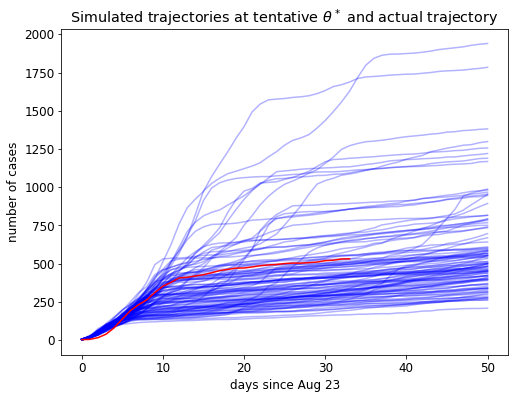

In [8]:

plt.figure(figsize=(8,6))
for i in range(len(aggregated_trajs['point_456_with_trajectories.dill'])):
    plt.plot(aggregated_trajs['point_456_with_trajectories.dill'][i], color='b', alpha=0.3)
plt.plot(np.cumsum(np.array(ACTUAL_TRAJ)), color='r')
plt.title(r'Simulated trajectories at tentative $\theta^*$ and actual trajectory')
plt.xlabel('days since Aug 23')
plt.ylabel('number of cases')

In [117]:

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks[f]) # log likelihood for corresponding param value
    
    for f in sampled_points2:
        param_vals[param].append(sampled_points2[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks2[f]) # log likelihood for corresponding param value
    

Text(0.5, 1.0, 'distribution of log likelihoods using weekly aggregation')

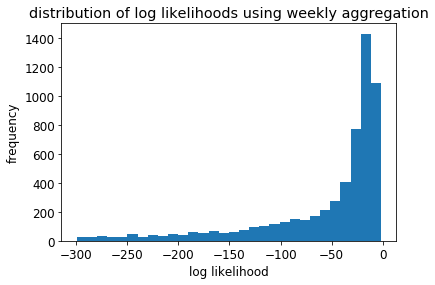

In [118]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [119]:
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
#df['file_name'] = sampled_points
subdf = df
df.shape

# TODO: save df

(7886, 8)

In [120]:
df


,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-96.888173,0.651268
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-244.428493,0.546052
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-21.290856,0.327567
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-3680.493690,0.991918
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-6.906553,0.458539
...,...,...,...,...,...,...,...,...
7881,0.290806,0.625967,1.705920,2.834365,1.296497,0.003375,-12.508775,0.310537
7882,0.575577,0.548734,2.056666,3.338652,0.767250,0.003067,-201.197007,0.649575
7883,0.622738,0.529162,0.894463,2.396398,1.222753,0.004282,-5.770916,0.294752
7884,0.763319,0.779013,1.935809,1.300518,0.654530,0.004546,-5789.292411,1.151100


In [121]:
log_priors = []

for row in range(df.shape[0]):
    log_prior = 0
    for param in UNCERTAINTY_PARAMS:
        log_prior += -np.log(PARAM_SDS[param]*np.sqrt(2*np.pi)) -1/2 * (df.loc[row][param]-PARAM_MEANS[param])**2/PARAM_SDS[param]**2
    log_priors.append(log_prior)


In [122]:
df['log_prior'] = log_priors
df['log_posterior'] = df['log_likelihood'] + df['log_prior']

In [15]:
df.to_csv('Oct6_posterior_data.csv')

In [ ]:
subdf_diff = subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult', \
               'log_posterior']]
#subtract from entry with largest log -- to change to posterior
subdf_diff = subdf_diff.sub(subdf_diff.iloc[subdf['log_posterior'].idxmax()])
subdf_diff = subdf_diff.dropna(subset=['log_posterior'])


# TODO: scale distances by sd
subdf_diff

In [19]:
subdf_diff.std()

outside_infection_rate_mult            1.011598
cases_isolated_per_contact_trace       0.257853
initial_ID_prevalence                  0.000607
combined_spread_mult                   0.353335
log_posterior                       1482.788439
dtype: float64

In [18]:
subdf.iloc[subdf['log_posterior'].idxmax()]

vax_susc_mult                       0.499013
vax_transmission_mult               0.496466
contacts_per_day_mult               1.422252
outside_infection_rate_mult         1.156892
cases_isolated_per_contact_trace    1.219596
initial_ID_prevalence               0.005000
log_likelihood                     -5.204682
combined_spread_mult                0.352353
log_prior                           3.774952
log_posterior                      -1.429730
Name: 5442, dtype: float64

In [20]:
params_diff = subdf_diff[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']]
logposterior_diff = subdf_diff['log_posterior']
quadratic = PolynomialFeatures(degree = 2,interaction_only=False,include_bias = False)


'outside_infection_rate_mult'

0.7520704596989791


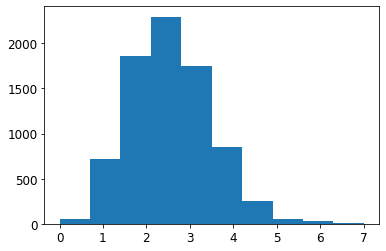

In [71]:
param_distances = np.sqrt(np.square(params_diff/params_diff.std()).sum(axis=1))

plt.hist(param_distances)
cutoff_radius = np.quantile(param_distances,0.01)
print(cutoff_radius)

In [72]:
reg_x = params_diff[param_distances < cutoff_radius]
reg_y = logposterior_diff[param_distances < cutoff_radius]
reg_x.reset_index(drop=True, inplace=True)
reg_y.reset_index(drop=True, inplace=True)

In [73]:
reg_input_quadratic = pd.DataFrame(quadratic.fit_transform(reg_x.to_numpy()),\
                                     columns = quadratic.get_feature_names(reg_x.columns))


In [74]:
norm_reg_input_quadratic = reg_input_quadratic / reg_input_quadratic.abs().max()


In [75]:
#norm_reg_input_quadratic.isnull().sum()
#np.isinf(norm_reg_input_quadratic).sum()
reg_y.isnull().sum()
#np.isinf(reg_y).sum()

0

In [76]:

model = OLS(reg_y, norm_reg_input_quadratic)
results = model.fit()

In [83]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          log_posterior   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              20.50
Date:                Thu, 07 Oct 2021   Prob (F-statistic):                    1.31e-18
Time:                        09:35:08   Log-Likelihood:                         -293.74
No. Observations:                  79   AIC:                                      615.5
Df Residuals:                      65   BIC:                                      648.6
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
outside_infection_rate_mult                                      0.1289      3.721      0.035      0.972      -7.303       7.561
cases_isolated_per_contact_trace                                -5.0453      3.712     -1.359      0.179     -12.458       2.368
initial_ID_prevalence                                            7.6486      3.402      2.248      0.028       0.855      14.443
combined_spread_mult                                            47.1620      4.379     10.770      0.000      38.416      55.908
outside_infection_rate_mult^2                                   -6.7550      5.936     -1.138      0.259     -18.611       5.101
outside_infection_rate_mult cases_isolated_per_contact_trace     5.3110      4.526      1.173      0.245      -3.728      14.350
outside_infection_rate_mult initial_ID_prevalence               -0.5997      3.915     -0.153      0.879      -8.419       7.220
outside_infection_rate_mult combined_spread_mult                -2.3716      3.500     -0.678      0.500      -9.361       4.618
cases_isolated_per_contact_trace^2                             -13.6254      4.616     -2.952      0.004     -22.844      -4.407
cases_isolated_per_contact_trace initial_ID_prevalence           5.0560      3.970      1.273      0.207      -2.874      12.986
cases_isolated_per_contact_trace combined_spread_mult            6.6651      4.029      1.654      0.103      -1.382      14.712
initial_ID_prevalence^2                                         -8.1787      4.778     -1.712      0.092     -17.721       1.363
initial_ID_prevalence combined_spread_mult                     -12.4809      4.166     -2.996      0.004     -20.800      -4.161
combined_spread_mult^2                                         -66.2395      7.227     -9.166      0.000     -80.672     -51.807
==============================================================================
Omnibus:                       14.724   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               49.744
Skew:                          -0.317   Prob(JB):                     1.58e-11
Kurtosis:                       6.835   Cond. No.                         4.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
results.params

outside_infection_rate_mult                                      0.128908
cases_isolated_per_contact_trace                                -5.045258
initial_ID_prevalence                                            7.648637
combined_spread_mult                                            47.162016
outside_infection_rate_mult^2                                   -6.754999
outside_infection_rate_mult cases_isolated_per_contact_trace     5.311024
outside_infection_rate_mult initial_ID_prevalence               -0.599707
outside_infection_rate_mult combined_spread_mult                -2.371629
cases_isolated_per_contact_trace^2                             -13.625404
cases_isolated_per_contact_trace initial_ID_prevalence           5.056024
cases_isolated_per_contact_trace combined_spread_mult            6.665069
initial_ID_prevalence^2                                         -8.178659
initial_ID_prevalence combined_spread_mult                     -12.480886
combined_spread_mult^2                

In [79]:
unnorm_coef = results.params / reg_input_quadratic.abs().max()

In [80]:
unnorm_coef

outside_infection_rate_mult                                     1.882992e-01
cases_isolated_per_contact_trace                               -2.910271e+01
initial_ID_prevalence                                           2.012514e+04
combined_spread_mult                                            1.933956e+02
outside_infection_rate_mult^2                                  -1.441324e+01
outside_infection_rate_mult cases_isolated_per_contact_trace    8.482532e+01
outside_infection_rate_mult initial_ID_prevalence              -4.644420e+03
outside_infection_rate_mult combined_spread_mult               -3.084357e+01
cases_isolated_per_contact_trace^2                             -4.533666e+02
cases_isolated_per_contact_trace initial_ID_prevalence          1.601450e+05
cases_isolated_per_contact_trace combined_spread_mult           3.749375e+02
initial_ID_prevalence^2                                        -5.662286e+07
initial_ID_prevalence combined_spread_mult                     -2.618761e+05

In [81]:
# map regression results to hessian matrix

hessian = np.zeros((4,4))

counter = 0
for i in range(4):
    for j in range(i, 4):
        if i == j:
            hessian[i,j] = -2 * unnorm_coef[4+counter]
        else:
            hessian[i,j] = -unnorm_coef[4+counter]
        counter += 1

# fill in symmetric lower triangular part
for i in range(1,4):
    for j in range(i):
        hessian[i,j] = hessian[j,i]
    
print(hessian)

[[ 2.88264883e+01 -8.48253180e+01  4.64441957e+03  3.08435676e+01]
 [-8.48253180e+01  9.06733168e+02 -1.60144951e+05 -3.74937506e+02]
 [ 4.64441957e+03 -1.60144951e+05  1.13245726e+08  2.61876050e+05]
 [ 3.08435676e+01 -3.74937506e+02  2.61876050e+05  2.22769575e+03]]


In [164]:
# order of parameters in the eigenvectors:
#   outside_infection_rate_mult                                     
#   cases_isolated_per_contact_trace                               
#   initial_ID_prevalence                                         
#   combined_spread_mult 
np.set_printoptions(linewidth = 100)


np.linalg.eig(hessian)


(array([1.13246558e+08, 1.91341306e+01, 6.89479882e+02, 1.62239645e+03]),
 array([[-4.10131225e-05,  9.93004125e-01,  1.17372336e-01,  1.29050418e-02],
        [ 1.41414025e-03,  1.17456328e-01, -9.93059170e-01, -5.95783056e-03],
        [-9.99996325e-01,  1.53391844e-04, -1.39195014e-03, -2.32120644e-03],
        [-2.31248327e-03, -1.21158754e-02, -7.43517533e-03,  9.99896283e-01]]))

In [165]:
post_mean = np.matmul(np.linalg.inv(hessian), unnorm_coef[:4]) + subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']].iloc[subdf['log_posterior'].idxmax()]
post_mean

# put 95% credible intervals in main paper
# put mean and covariance in SI
# turn covar into correlation matrix

outside_infection_rate_mult         1.507614
cases_isolated_per_contact_trace    0.935812
initial_ID_prevalence               0.004539
combined_spread_mult                0.309119
Name: 4997, dtype: float64

In [166]:
post_covar = np.linalg.inv(hessian)

post_covar

array([[ 5.15540262e-02,  5.92653301e-03,  7.70515846e-06, -6.22089910e-04],
       [ 5.92653301e-03,  2.15134155e-03,  2.95494756e-06, -6.73371936e-05],
       [ 7.70515846e-06,  2.95494756e-06,  1.61910546e-08, -1.51267664e-06],
       [-6.22089910e-04, -6.73371936e-05, -1.51267664e-06,  6.23996350e-04]])

In [167]:
np.corrcoef(covar)

array([[ 1.        ,  0.96705129,  0.93535976, -0.83224944],
       [ 0.96705129,  1.        ,  0.98680088, -0.86984436],
       [ 0.93535976,  0.98680088,  1.        , -0.93176405],
       [-0.83224944, -0.86984436, -0.93176405,  1.        ]])

In [168]:
cred_ints = []

for i in range(4):
    cred_ints.append([post_mean[i] - 1.96 * np.sqrt(post_covar[i,i]), post_mean[i] + 1.96 * np.sqrt(post_covar[i,i])] )

In [169]:
cred_ints

[[1.0625855437406486, 1.9526416028187785],
 [0.8449020113911669, 1.0267216330564497],
 [0.004289352935305952, 0.0047881497087090465],
 [0.2601578689345606, 0.3580791511828847]]

In [102]:
def estimate_marginal_distribution(param_vals, logliks, num_bins):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=num_bins)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    bin_width = bin_boundaries[1] - bin_boundaries[0]
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.log(np.sum(likelihoods))
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods, bin_width
   

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


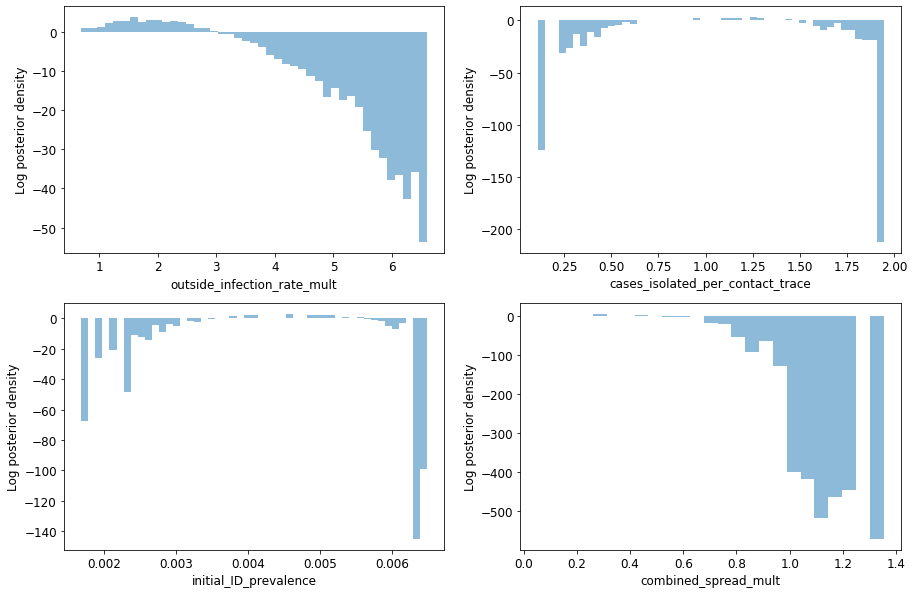

In [104]:
plt.figure(figsize=(15,10))


for idx in range(4):
    param = subdf_diff.columns[idx]
    plt.subplot(2,2,idx+1)
    centres, likelihoods, bin_width = estimate_marginal_distribution(df[param], df['log_posterior'], 50)
    plt.bar(centres, likelihoods, width = bin_width,
            alpha=0.5)
    plt.xlabel("{}".format(param))
    plt.ylabel('Log posterior density')
    #plt.title("{}".format(param))

In [141]:
max_posterior_point = subdf.iloc[subdf['log_posterior'].idxmax()]
max_posterior_point

vax_susc_mult                       0.526847
vax_transmission_mult               0.249375
contacts_per_day_mult               1.651973
outside_infection_rate_mult         1.635626
cases_isolated_per_contact_trace    0.950860
initial_ID_prevalence               0.004590
log_likelihood                     -2.468432
combined_spread_mult                0.217041
log_prior                           4.103804
log_posterior                       1.635372
Name: 4997, dtype: float64

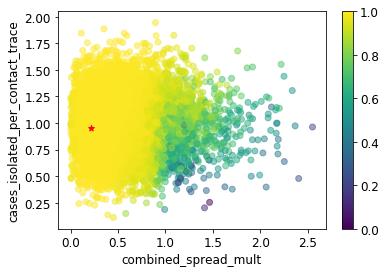

In [127]:
key1, key2 = 'combined_spread_mult', 'cases_isolated_per_contact_trace'
plt.scatter(df[key1], df[key2],
           c=df['log_posterior'], alpha=0.5)
plt.xlabel(key1)
plt.ylabel(key2)
plt.scatter(max_posterior_point[key1], max_posterior_point[key2], marker='*', color='r')
plt.colorbar()

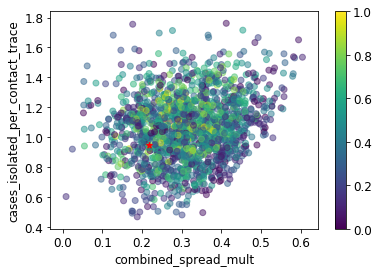

In [129]:
subdf_plot = df[df['log_posterior'] >= -10]
key1, key2 = 'combined_spread_mult', 'cases_isolated_per_contact_trace'
plt.scatter(subdf_plot[key1], subdf_plot[key2],
           c=subdf_plot['log_posterior'], alpha=0.5)
plt.xlabel(key1)
plt.ylabel(key2)
plt.scatter(max_posterior_point[key1], max_posterior_point[key2], marker='*', color='r')
plt.colorbar()

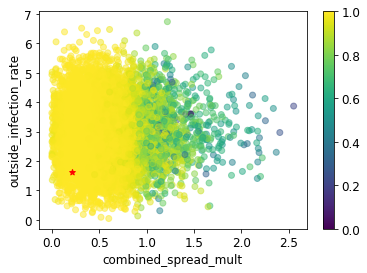

In [134]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_posterior'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['outside_infection_rate_mult'], marker='*', color='r')

plt.colorbar()
plt.show()



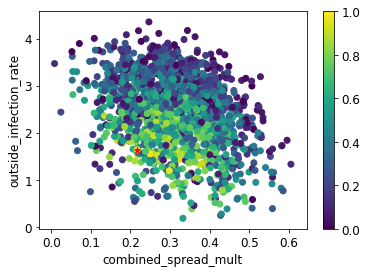

In [135]:
plt.scatter(subdf_plot['combined_spread_mult'], subdf_plot['outside_infection_rate_mult'],
           c=subdf_plot['log_posterior'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['outside_infection_rate_mult'], marker='*', color='r')

plt.colorbar()

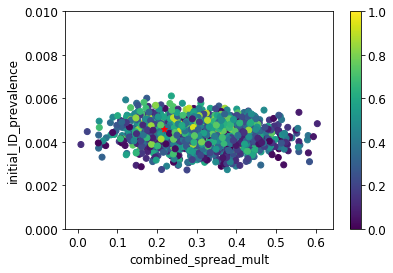

In [138]:
plt.scatter(subdf_plot['combined_spread_mult'], subdf_plot['initial_ID_prevalence'],
           c=subdf_plot['log_posterior'])
plt.xlabel('combined_spread_mult')
plt.ylabel('initial_ID_prevalence')
plt.ylim(0, 0.01)
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['initial_ID_prevalence'], marker='*', color='r')

plt.colorbar()

In [123]:
max_posterior_point = subdf.iloc[subdf['log_posterior'].idxmax()]

In [124]:
max_posterior_point

vax_susc_mult                       0.526847
vax_transmission_mult               0.249375
contacts_per_day_mult               1.651973
outside_infection_rate_mult         1.635626
cases_isolated_per_contact_trace    0.950860
initial_ID_prevalence               0.004590
log_likelihood                     -2.468432
combined_spread_mult                0.217041
log_prior                           4.103804
log_posterior                       1.635372
Name: 4997, dtype: float64